# 一维量子态传输

DeepQuantum 模拟一维简单量子态传输，通过给定的哈密顿量得到时间演化算符，对其进行特征值分解，得到对应的量子门，从而构造相应的量子线路进行求解。
DeepQuantum 支持大规模的多比特模拟，通过设置mps=True可以使用张量网络求解。 \
考虑简单的N个比特一维链体系，给定的哈密顿量如下：$$H =\sum_n\sigma_n^x\sigma_{n+1}^x$$ \
$\sigma_n^x$ 代表作用在第n个比特的pauli x 算符，n取值为1,...,N-1。 \
因为哈密顿量中同时加入$\sigma^x$和$\sigma^y$时会出现不对易的情况，为了方便分解多比特的时间演化算符为多个两比特时间演化算符，此处只考虑$\sigma^x_n \cdot \sigma^x_{n+1}$部分，因此是文献中的模型的简化(https://arxiv.org/pdf/quant-ph/0309131)。

In [1]:
import deepquantum as dq
import torch
import torch.nn as nn
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

首先考虑简单的两个比特情况，写出给定哈密顿量的矩阵形式，将时间演化算符进行特征值分解，得到由特征向量组成的矩阵u和对角矩阵u_diag，再通过自定义这两个量子门进行线路演化，最后对每个比特测量相应的概率。

In [2]:
def get_probs_(sigmaz_exp):
    """Obtain probs of |0> and |1> for each qubit
    input: expectation values of sigmaz, type: torch.Tensor
    output: prob for |0> and |1> for each qubit, size: (num_qubits, batch, 2)
    """
    probs_all = torch.stack(((sigmaz_exp+1)/2, (1-sigmaz_exp)/2)).transpose(0,-1)

    return probs_all

In [3]:
sigmax_d2 = np.matrix([[0, 1], [1, 0]])
sigmax_d4 = np.kron(sigmax_d2, sigmax_d2)   # H
u = la.eig(sigmax_d4)[1]                    # 特征值分解
udag = u.transpose()
eig_val = la.eig(sigmax_d4)[0]

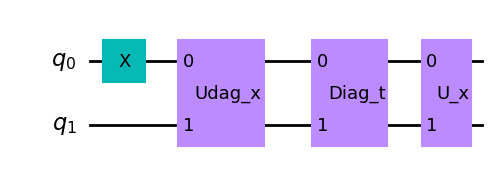

In [4]:
# batch = 1
nqubit = 2

tlist = np.linspace(0, 2*np.pi, 100)
probs_q0 = []
probs_qend = []
for i in range(100) :
    t = tlist[i]

    u_exp = np.diag(np.exp(eig_val*(-1j)*t))              # 构造对角矩阵Lambda

    cir = dq.QubitCircuit(nqubit, mps=True, chi=2)        # mps=True 使用张量网络 
    cir.x(0)                                              # initial state 10
    cir.any(unitary=udag, wires=[0,1], name="udag_x")     # u*exp(-i*Lambda*t)*u^dag
    cir.any(unitary=u_exp, wires=[0,1], name="diag_t")
    cir.any(unitary=u, wires=[0,1], name="u_x")


    for i in range(nqubit):                               # sigmaz 平均值
        cir.observable(i)
    cir()

    probs_q0.append((get_probs_(cir.expectation()).tolist())[0])
    probs_qend.append((get_probs_(cir.expectation()).tolist())[1])

cir.draw()

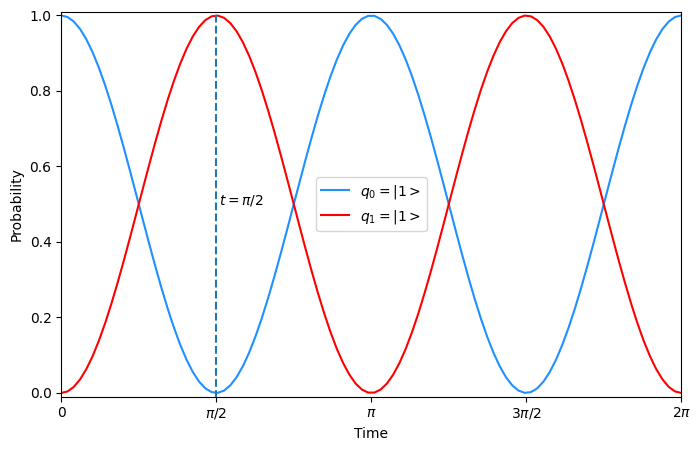

In [5]:
probs_q0 = np.matrix(probs_q0)
probs_qend = np.matrix(probs_qend)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
plt.xlim(0, 2*np.pi)
plt.ylim(-0.01, 1.01)
plt.plot(tlist, probs_q0[:,1], label="$q_0=|1>$", color="dodgerblue")
plt.plot(tlist, probs_qend[:,1], label="$q_1=|1>$", color="red")
plt.vlines(np.pi/2, -0.1, 1.1, ls="--")
plt.text(1.6, 0.5, "$t=\pi/2$")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.xticks([0, np.pi/2, np.pi, np.pi/2*3, 2*np.pi], 
           [0, "$\pi/2$", "$\pi$", "$3\pi/2$", "$2\pi$"]
           )
plt.legend()
plt.show()

对于多比特情况，哈密顿量的矩阵维度随比特数增多呈指数增长，但是容易证明其对应的时间演化算符特征值分解之后的结果可以写成张量积的形式，这说明时间演化算符可以分解成多个量子门的组合。下面给出任意多个比特的模拟，nqubit的值可以任意选择。

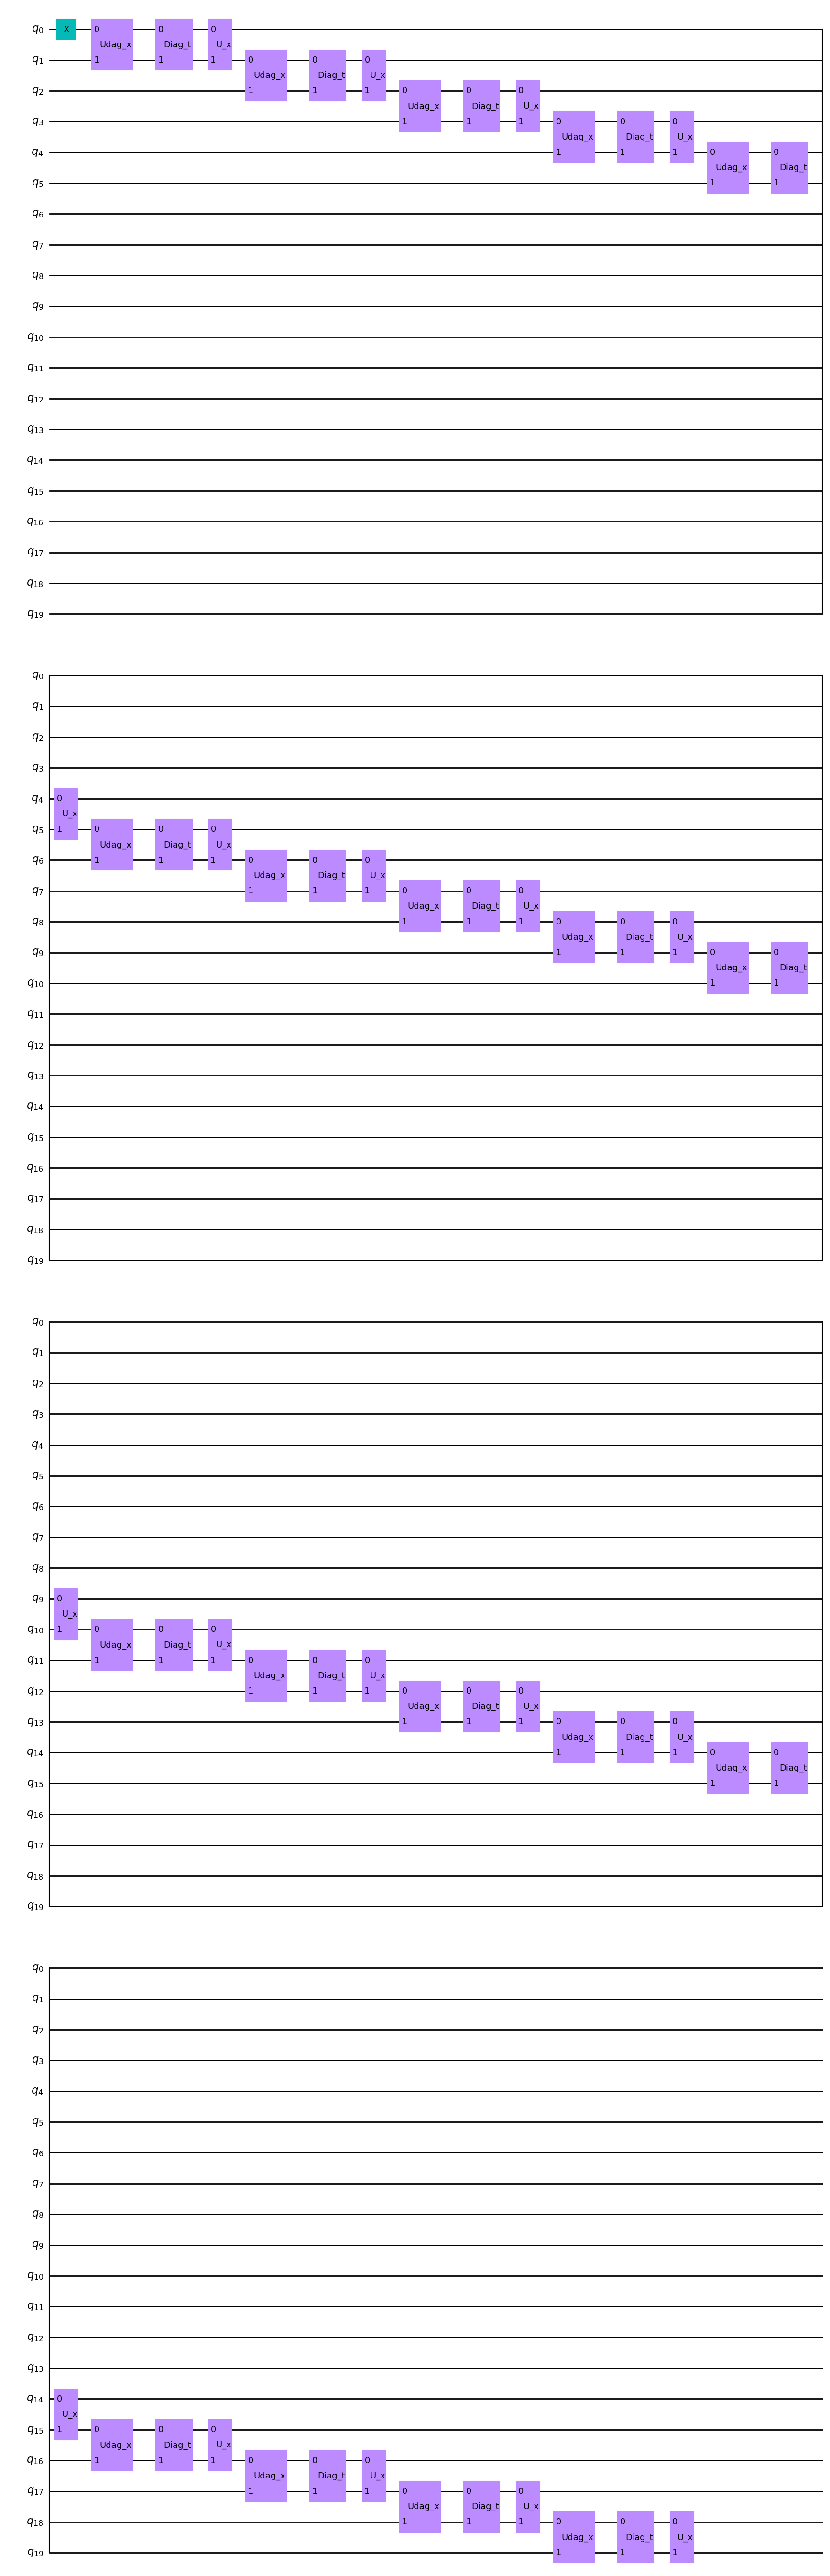

In [6]:
# batch = 1
nqubit = 20

tlist = np.linspace(0, 2*np.pi, 100)                     # time slicing 
allprobs_q0 = []
allprobs_q1 = []
allprobs_qend = []
allprobs_qend2 = []
for i in range(100) :
    t = tlist[i]
    cir = dq.QubitCircuit(nqubit, mps=True, chi=2)     # mps=True using Tensornetwork
    cir.x(0)                                           # initial state 10
     
    for q in range(nqubit-1):
        u_exp = np.diag(np.exp(eig_val*(-1j)*t))       # 构造对角矩阵Lambda        
        cir.any(unitary=udag, wires=[q,q+1], name="udag_x")  # u*exp(-i*Lambda*t)*u^dag
        cir.any(unitary=u_exp, wires=[q,q+1], name="diag_t")
        cir.any(unitary=u, wires=[q,q+1], name="u_x")

    for i in range(nqubit):                             # sigmaz 平均值
        cir.observable(i)
    cir()

    allprobs_q0.append((get_probs_(cir.expectation()).tolist())[0])
    allprobs_q1.append((get_probs_(cir.expectation()).tolist())[1])
    allprobs_qend.append((get_probs_(cir.expectation()).tolist())[-1])
    allprobs_qend2.append((get_probs_(cir.expectation()).tolist())[-2])

cir.draw()

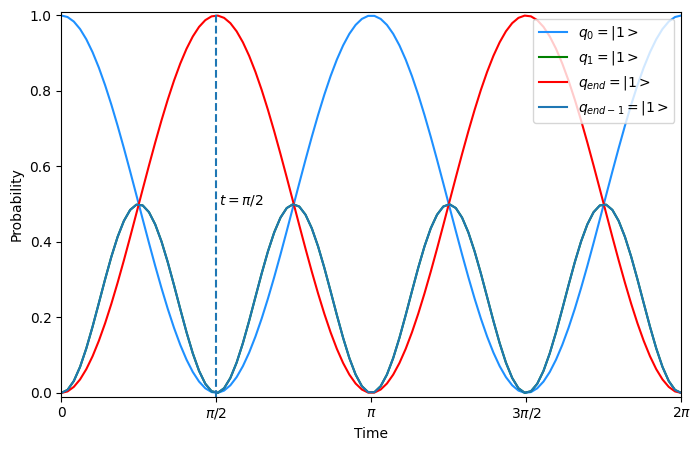

In [7]:
allprobs_q0 = np.matrix(allprobs_q0)
allprobs_q1 = np.matrix(allprobs_q1)
allprobs_qend = np.matrix(allprobs_qend)
allprobs_qend2 = np.matrix(allprobs_qend2)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
plt.xlim(0, 2*np.pi)
plt.ylim(-0.01, 1.01)
plt.plot(tlist, allprobs_q0[:,1], label="$q_0=|1>$", color="dodgerblue")
plt.plot(tlist, allprobs_q1[:,1], label="$q_1=|1>$", color="green")
plt.plot(tlist, allprobs_qend[:,1], label="$q_{end}=|1>$", color="red")
plt.plot(tlist, allprobs_qend2[:,1], label="$q_{end-1}=|1>$")
plt.vlines(np.pi/2, -0.1, 1.1, ls="--")
plt.text(1.6, 0.5, "$t=\pi/2$")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.xticks([0, np.pi/2, np.pi, np.pi/2*3, 2*np.pi], 
           [0, "$\pi/2$", "$\pi$", "$3\pi/2$", "$2\pi$"]
           )
plt.legend()
plt.show()